# Effect of L2 Regulariaztion on Network Weights

A simple comparison of how weight decay affects the parameters of a small fully connected neural network. 

## Environment Setup

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import sys
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline


In [ ]:
# mount google drive for acess to plotting utils
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# use custom matplotlib style sheet for plots
plt.style.use('./drive/MyDrive/Colab Notebooks/plotting/web.mplstyle')

# import custom matplotlib plotting function
sys.path.append('/content/drive/MyDrive/Colab Notebooks/plotting')
import utils

In [ ]:
# get gpu device if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

Using cuda


## Downloading and Setting up the Data

In [ ]:
# download CIFAR training data 
train_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# download CIFAR test data
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
) 

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
batch_size = 64

# create respective dataloaders from datasets
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

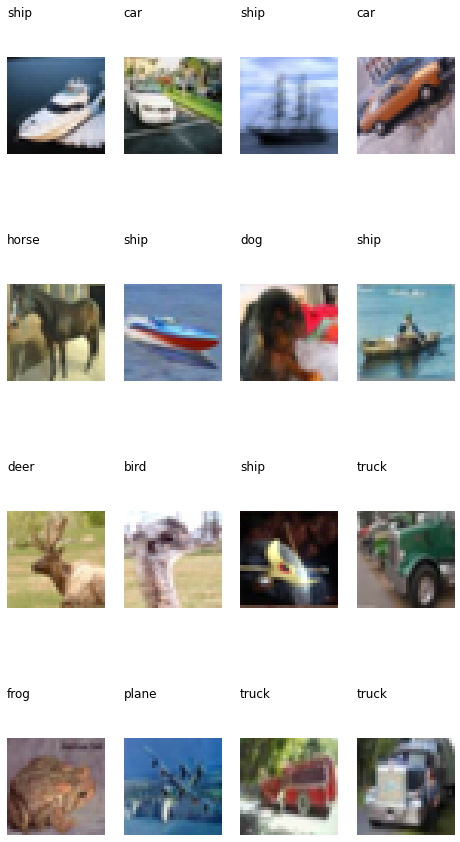

In [ ]:
# map label ints to string categories
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

# print some of the pictures from the training set
fig = plt.figure(figsize=(8, 16))
rows, cols = 4, 4
sample_idxs = np.random.choice(len(train_data), rows * cols, replace=False)
for i, idx in enumerate(sample_idxs):
  image, label = train_data[idx]
  fig.add_subplot(rows, cols, i + 1)
  # imshow requires channel dimension be last
  plt.imshow(torch.moveaxis(image, 0, 2))
  plt.title(classes[label])
  plt.axis("off")


## Model Setup

In [ ]:
# define simple linear model
class LinearNN(nn.Module):
  def __init__(self):
    super(LinearNN, self).__init__()
    self.flatten = nn.Flatten(1)  # flatten all dimensions except batch
    self.linear = nn.Linear(32 * 32 * 3, 10)

  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear(x)
    return logits
    

# define three layer linear neural network
class ThreeLayerNN(nn.Module):
    def __init__(self):
        super(ThreeLayerNN, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits


# define four layer linear neural network
class FourLayerNN(nn.Module):
    def __init__(self):
        super(FourLayerNN, self).__init__()
        self.flatten = nn.Flatten()
        self.layers = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),           
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.layers(x)
        return logits


In [ ]:
# training loop
def train(trainloader, model, loss_fn, optimizer, printing):
  size = len(trainloader.dataset)
  num_batches = len(trainloader)
  train_loss, count, correct = 0.0, 0, 0
  model.train()

  for batch, (X, y) in enumerate(trainloader):
    X, y = X.to(device), y.to(device)
    # forward pass
    pred = model(X)
    loss = loss_fn(pred, y)
    correct += (pred.argmax(1) == y).sum().item()
    train_loss += loss

    # backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if printing: 
      if batch % 200 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"Loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

  correct /= size
  train_loss /= num_batches
  
  return train_loss, correct


# test loop
def test(testloader, model, loss_fn, printing):
  size = len(testloader.dataset)
  num_batches = len(testloader)
  test_loss, correct = 0.0, 0

  with torch.no_grad():
    for (X, y) in testloader:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss = loss_fn(pred, y)
      correct += (pred.argmax(1) == y).sum().item()
      test_loss += loss.item()
  
  if printing:
    print(f"Test Accuracy: {(100 * correct):>0.1f}%, Avg Loss: {test_loss:>8f}\n")
  
  test_loss /= num_batches
  correct /= size

  return test_loss, correct

In [ ]:
# train and validate model
def train_model(model, optimizer, trainloader, testloader, 
                epochs=10, printing=False):
  
  model_states = {}
  metrics = {'train_loss': [],
            'train_acc': [],
            'test_loss': [],
            'test_acc': []
            }
  loss_fn = nn.CrossEntropyLoss()

  for epoch in range(epochs):
    if printing:
      print(f"Epoch {epoch+1}\n{('-'*30)}")
      
    train_loss, train_acc = train(trainloader, model, loss_fn, optimizer, False)
    test_loss, test_acc = test(testloader, model, loss_fn, False)

    metrics['train_loss'].append(train_loss)
    metrics['train_acc'].append(train_acc)
    metrics['test_loss'].append(test_loss)
    metrics['test_acc'].append(test_acc)

    # save model params
    model_states[epoch] = {}
    for param in model.state_dict():
      model_states[epoch][param] = np.array(model.state_dict()[param].cpu())

    if not printing:
      print(f"\rEpoch {epoch+1}: Train Loss {train_loss:0>5.3f} | "
            f"Train Acc {(train_acc*100):>0.1f}% | Test Loss "
            f"{test_loss:0>5.3f} | Test Acc {(test_acc*100):>0.1f}%",
            end=''
           )
    
  print("\nDone!")

  return model_states, metrics

## Results

### Plotting Functions

In [ ]:
def plot_metric(metric_dict, metric, title):
  """
  Plots either the loss or accuracy of the model on the test and training
  sets. metric_dict must be a dictionary where metric_dict['train_<metric>']
  returns the model's training performance on the specified metric as a list.
  The same goes for the test data.
  """
  fig, ax = plt.subplots(figsize=(6,4))

  ax.plot(metric_dict['train_'+metric], label='Train', c='darkblue')
  ax.plot(metric_dict['test_'+metric], label='Test', c='skyblue')
  ax.set_xlim(-1)
  ax.set_ylim(0)
  ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncol=2, borderaxespad=0.)
  utils.align_ytick_labels_right(ax)
  if metric == 'acc': metric = 'accuracy'
  description = f"\nAverage {metric} on epochs of training"
  ax.set_title(title + description)

  return fig



In [ ]:
def plot_layers(ax, param_dict):
  """
  Plots a calculated statistic for each model layer in param_dict.
  """
  colors = plt.cm.Reds(np.linspace(0,1,5)) 
  for i, layer in enumerate(param_dict.keys()):
    ax.plot(param_dict[layer], color=colors[i+1])

  ax.set_xlim(-1)
  ax.set_ylim(0)
  utils.align_ytick_labels_right(ax)


In [ ]:
def const_plots(states):
  """
  Plots the percentage of constant parameter weights, per layer, during
  training, at four different 'tolerance' levels. Model is assumed to 
  have four layers total.
  """
  tolerances = [0, 0.001, 0.01, 0.1]
  fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)
  consts = {}
  epochs = max(states.keys())
  layers = [layer for layer in states[0] if 'weight' in layer]  

  for ax, tolerance in zip(fig.axes, tolerances):
    for layer in layers:
      consts[layer] = []
      for epoch in range(epochs):
        num_const = np.isclose(states[epoch][layer], states[epoch+1][layer], 
                               rtol=tolerance, atol=0).sum()
        num_const = num_const / states[epoch][layer].size * 100
        consts[layer].append(num_const)

    plot_layers(ax, consts)
    ax.set_title(f"Tolerance: {tolerance}", pad=2)

  lines = axes[0, 0].get_lines()
  labels = ['layer 0', 'layer 1', 'layer 2', 'layer 3']
  fig.legend(lines, labels, bbox_to_anchor=(0.005, 1.07), loc='upper left',
          ncol=4)
  fig.tight_layout(h_pad=2, w_pad=2)

  return fig


In [ ]:
def plot_weight_var(states, title):
  """
  Plots the variance of each layer. 
  """
  layers = [layer for layer in states[0] if 'weight' in layer]
  vars = {}

  # calculate variance
  for layer in layers:
    vars[layer] = []
    for epoch in range(max(states.keys())):
      vars[layer].append(states[epoch][layer].var())

  fig, ax = plt.subplots()
  plot_layers(ax, vars)
  ax.set_title(title, pad=2)

  return fig
  

### Four Layer Model with No Regularization

In [ ]:
# create model and train
epochs = 50
model = FourLayerNN().to(device)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            weight_decay=0,
                            momentum=0.9
                            )
states, metrics = train_model(model,
                              optimizer,
                              train_dataloader,
                              test_dataloader,
                              epochs
                              )

Epoch 50: Train Loss 0.284 | Train Acc 89.9% | Test Loss 2.723 | Test Acc 53.0%
Done!


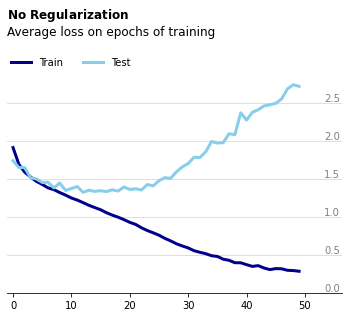

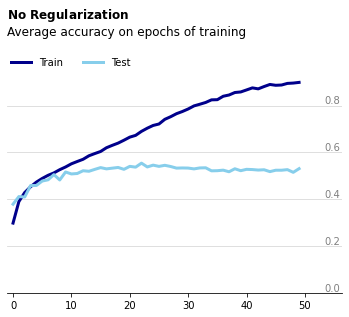

In [ ]:
# plot loss and accuracy curves
loss_fig = plot_metric(metrics, 'loss', r"$\bf{No\ Regularization}$")
acc_fig = plot_metric(metrics, 'acc', r"$\bf{No\ Regularization}$")


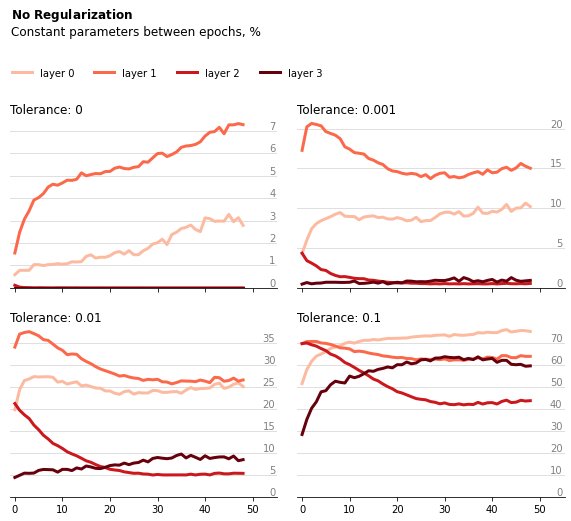

In [ ]:
# plot const plots
cfig = const_plots(states)
description = "\nConstant parameters between epochs, %"
t = cfig.suptitle(r"$\bf{No\ Regularization}$" + description, 
               ha='left', x = 0.02, y = 1.2)

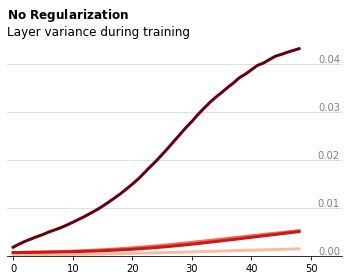

In [ ]:
title = r"$\bf{No\ Regularization}$" + "\nLayer variance during training"
vfig = plot_weight_var(states, title)


### Four Layer Model with Regularization

In [ ]:
# run test with weight decay 0.001
# create model and train
epochs = 50
model = FourLayerNN().to(device)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            weight_decay=0.001,
                            momentum=0.9
                            )
reg_states, reg_metrics = train_model(model,
                              optimizer,
                              train_dataloader,
                              test_dataloader,
                              epochs
                              )

Epoch 50: Train Loss 0.964 | Train Acc 65.4% | Test Loss 1.323 | Test Acc 54.0%
Done!


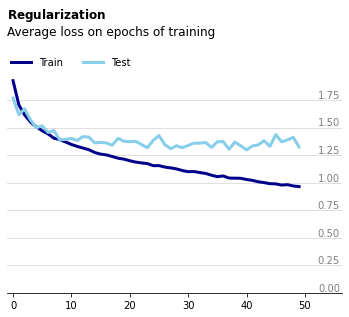

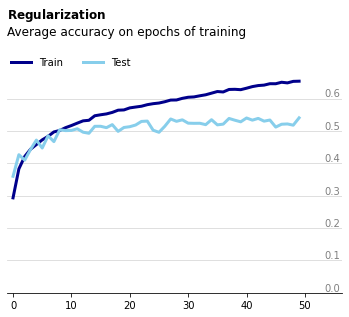

In [ ]:
# plot loss and accuracy curves
loss_fig = plot_metric(reg_metrics, 'loss', r"$\bf{Regularization}$")
acc_fig = plot_metric(reg_metrics, 'acc', r"$\bf{Regularization}$")

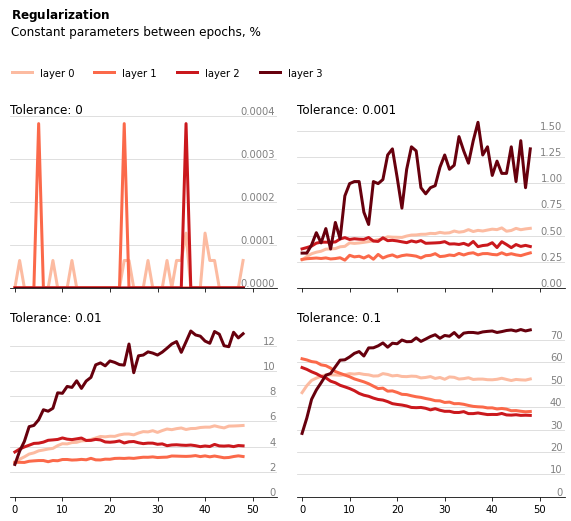

In [ ]:
# plot const plots
cfig = const_plots(reg_states)
description = "\nConstant parameters between epochs, %"
t = cfig.suptitle(r"$\bf{Regularization}$" + description, 
               ha='left', x = 0.02, y = 1.2)

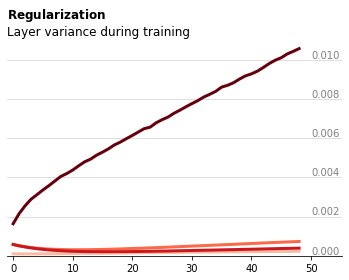

In [ ]:
title = r"$\bf{Regularization}$" + "\nLayer variance during training"
vfig = plot_weight_var(reg_states, title)


#### Regularization vs No Regularization

In [ ]:
def layer_const(layer1, layer2, tolerance):
  """
  Calculate percentage of parameter weights remaining constant between
  two epochs at a given tolerance.
  """
  num_const = np.isclose(layer1, layer2, rtol=tolerance, atol=0).sum()
  return num_const / layer1.size * 100


def param_diff(states, tol, all):
  """
  For a given tolerance, calculate the percentage of parameter weights
  remaining constant between epochs for each layer in the model (excluding
  biases).
  """
  layers = [layer for layer in states[0] if 'weight' in layer]  
  if not all: layers = layers[2:]
  # initialize array of zeros, length equal to number of epochs
  consts = [0] * max(states.keys())

  for epoch in range(len(consts)):
    for layer in layers:
      consts[epoch] += layer_const(states[epoch][layer], states[epoch+1][layer], tol)
    consts[epoch] /= len(layers) 

  return consts


def const_plots_avg(states, reg_states, all=True):
  """
  Plots the percentage of constant parameter weights, AVERAGED over all
  layers, during training, at four different 'tolerance' levels. Model 
  is assumed to have four layers total.
  """
  tolerances = [0, 0.001, 0.01, 0.1]
  fig, axes = plt.subplots(2, 2, figsize=(8,6), sharex=True)

  for ax, tol in zip(fig.axes, tolerances):
    ax.plot(param_diff(states, tol, all), 'darkgreen')
    ax.plot(param_diff(reg_states, tol, all), 'yellowgreen')

    ax.set_xlim(-1)
    ax.set_ylim(0)
    utils.align_ytick_labels_right(ax)
    ax.set_title(f"Tolerance: {tol}", pad=2)

  lines = axes[0, 0].get_lines()
  labels = ['no reg', 'reg']
  fig.legend(lines, labels, bbox_to_anchor=(0.005, 1.07), loc='upper left',
          ncol=2)

  fig.tight_layout(h_pad=2, w_pad=2)
  
  return fig

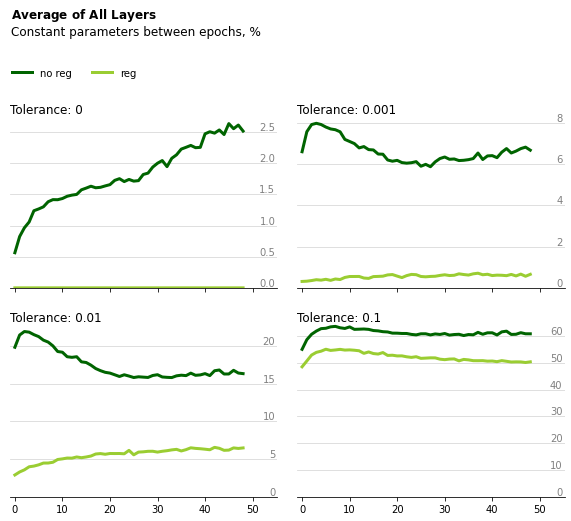

In [ ]:
cfig = const_plots_avg(states, reg_states)
description = "\nConstant parameters between epochs, %"
t = cfig.suptitle(r"$\bf{Average\ of\ All\ Layers}$" + description, 
               ha='left', x = 0.02, y = 1.2)

In [ ]:
cfig.savefig('./drive/MyDrive/comp_all', transparent=True, dpi=400, 
             bbox_extra_artists=(t,), bbox_inches='tight')

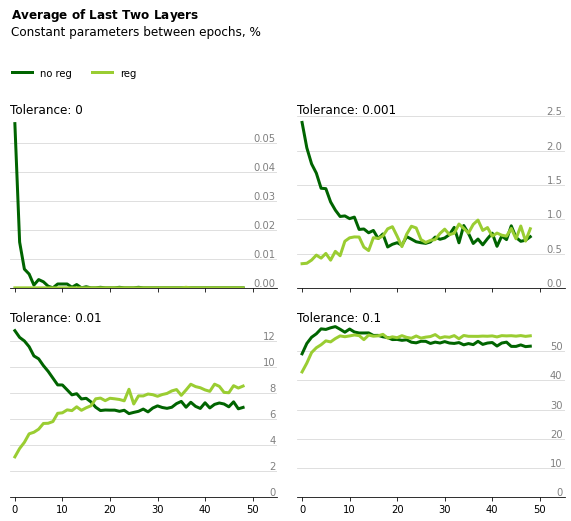

In [ ]:
cfig_all = const_plots_avg(states, reg_states, all=False)
description = "\nConstant parameters between epochs, %"
t = cfig_all.suptitle(r"$\bf{Average\ of\ Last\ Two\ Layers}$" + description, 
               ha='left', x = 0.02, y = 1.2)

#### Four Layer Model, No Regularization, 200 Epochs

In [ ]:
# create model and train
epochs = 200
model = FourLayerNN().to(device)
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.01,
                            weight_decay=0,
                            momentum=0.9
                            )
long_states, long_metrics = train_model(model,
                              optimizer,
                              train_dataloader,
                              test_dataloader,
                              epochs
                              )

Epoch 200: Train Loss 0.344 | Train Acc 92.1% | Test Loss 7.009 | Test Acc 49.5%
Done!


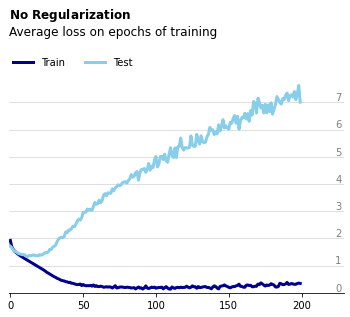

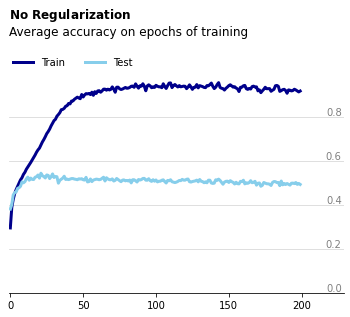

In [ ]:
# plot loss and accuracy curves
loss_fig = plot_metric(long_metrics, 'loss', r"$\bf{No\ Regularization}$")
acc_fig = plot_metric(long_metrics, 'acc', r"$\bf{No\ Regularization}$")

In [ ]:
acc_fig.savefig('./drive/MyDrive/long_acc', transparent=True, dpi=400, 
                 bbox_inches='tight')

In [ ]:
loss_fig.savefig('./drive/MyDrive/long_loss', transparent=True, dpi=400, 
                 bbox_inches='tight')